<a href="https://colab.research.google.com/github/micah-shull/AI_Agents/blob/main/014_Feedback_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let’s design a practical, testable strategy for this **“Feedback Intelligence Agent”**. The goal: quickly move from concept to prototype that you can show or evolve in the real world.

---

## 🧱 Project Overview: "Target Feedback Agent"

### 🎯 **Goal**

Capture employee feedback, summarize it, categorize it, and present actionable insights to store management.

---

## 🧠 High-Level Strategy (MVP First)

### 🟢 Phase 1 – **Collect & Analyze Feedback**

* **Input**: Employee submits feedback via text (simulate this at first with test examples).
* **Agent #1**:

  * Summarizes the idea
  * Categorizes the topic (e.g., inventory, process, customer issue)
  * Tags the urgency (low, medium, high)
* **Storage**: Append this structured insight to a list or table (CSV, Google Sheet, etc.)

---

### 🟡 Phase 2 – **Review Insights**

* Create a simple report showing:

  * Top categories
  * Count per category
  * High urgency items
* Format: table or natural-language weekly summary

---

### 🔵 Phase 3 – **Manager-Facing Output**

* Aggregate and surface:

  * Most mentioned issues
  * Suggested actions (via LLM)
  * Optional: dashboard or scheduled email

---

## 🔧 Tools We'll Use in the Notebook

| Component          | Tool/Lib                       |
| ------------------ | ------------------------------ |
| LLM reasoning      | OpenAI `gpt-4o-mini`           |
| Input simulation   | Hardcoded feedback list        |
| Output formatting  | `pandas` + print/chart         |
| (Optional) Storage | CSV, Google Sheet, or DB later |

---

## 🧭 Notebook Plan (in sections)

### 1. **Set Up**

* Install needed libraries
* Connect OpenAI

### 2. **Feedback Simulation**

* Create a sample list of employee feedback (e.g., 5–10 items)

### 3. **LLM-Powered Processing Agent**

* For each item:

  * Summarize it
  * Categorize it
  * Tag urgency
* Return structured result (`dict` or `DataFrame` row)

### 4. **Analysis**

* Group by category
* Count urgency levels
* Show manager-facing report (basic version)

---

## 🛠 Prompt Strategy (for Agent #1)

**System Prompt:**

> You are an assistant that helps a store manager understand feedback from employees. You will extract a short summary, a category, and an urgency level from their message.

**Format Example:**

```json
{
  "summary": "Register system crashes during peak hours",
  "category": "Technology",
  "urgency": "High"
}
```

We’ll use this schema in our code for consistent output.



##Pip Installs

In [1]:
!pip install -q transformers accelerate huggingface_hub litellm python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.3 MB/s eta 0:00:00


## Feedback Samples

In [7]:
import json

# Sample feedback data
feedback_data = [
    # GM: Merchandising
    {
        "department": "GM",
        "employee_feedback": "The shelves in aisle 12 are constantly messy because customers leave things everywhere and we don’t have time to fix it between tasks."
    },
    {
        "department": "GM",
        "employee_feedback": "Our pricing gun breaks down frequently. It slows down the whole price change process."
    },
    {
        "department": "GM",
        "employee_feedback": "We never have enough shopping carts near the entrance during busy hours."
    },
    {
        "department": "GM",
        "employee_feedback": "The planogram we receive doesn’t match the actual product layout — makes resets take longer."
    },
    {
        "department": "GM",
        "employee_feedback": "Too many tasks assigned during a single shift. We need more hands during truck unload days."
    },

    # OOF: Online Order Fulfillment
    {
        "department": "OOF",
        "employee_feedback": "Pick times are too short for some items that are far apart — leads to constant rushing."
    },
    {
        "department": "OOF",
        "employee_feedback": "Sometimes online orders include out-of-stock items — makes us look bad and causes delays."
    },
    {
        "department": "OOF",
        "employee_feedback": "The handheld scanner freezes mid-pick and we have to restart it almost daily."
    },
    {
        "department": "OOF",
        "employee_feedback": "We aren’t told when substitutes are approved — we waste time checking back."
    },
    {
        "department": "OOF",
        "employee_feedback": "There’s not enough space in the staging area when online orders pile up during weekends."
    },
    {
        "department": "GM",
        "employee_feedback": "Customers constantly leave items in the wrong places and we don’t have time to fix it all during shift changes."
    },
    {
        "department": "GM",
        "employee_feedback": "We barely have enough carts in the front during rush hours — customers get annoyed."
    },
    {
        "department": "GM",
        "employee_feedback": "It’s frustrating when planograms are wrong or outdated — we waste a lot of time fixing shelves that shouldn't need changing."
    },
    {
        "department": "OOF",
        "employee_feedback": "I often can’t find items in time because they're far apart, and the pick times are too short."
    },
    {
        "department": "OOF",
        "employee_feedback": "The scanner crashes a lot — restarting it wastes at least 10 minutes each time."
    }
]

# Save to JSON
with open("sample_feedback.json", "w") as f:
    json.dump(feedback_data, f, indent=2)

print("✅ Sample feedback saved to sample_feedback.json")


✅ Sample feedback saved to sample_feedback.json


## Load API Key

In [11]:
import json
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv("/content/API_KEYS.env", override=True)

# Grab API key
api_key = os.getenv("OPENAI_API_KEY")

if not api_key:
    raise ValueError("❌ OPENAI_API_KEY not found in environment. Make sure your .env file is loaded correctly.")

# Set up OpenAI client
client = OpenAI(api_key=api_key)

# Load sample feedback
with open("sample_feedback.json", "r") as f:
    feedback_list = json.load(f)

print(f"✅ Loaded {len(feedback_list)} feedback entries")

✅ Loaded 15 feedback entries


# Feedback Function

### 🧠 **Purpose**

This function uses an OpenAI model to **analyze raw employee feedback** and return a structured, machine-readable output.

Specifically, it:

1. **Summarizes** the employee's feedback into 1 clear sentence
2. **Assigns a topic tag** — a short label that helps group similar feedback
3. **Includes the department** (already known from a dropdown) to give context to the model and output

This structure allows us to later:

* Group similar feedback by topic
* Count occurrences
* Generate manager-facing reports or dashboards

---

### 🧪 **Example Input**

```python
analyze_feedback(
    "The handheld scanner freezes mid-pick and we have to restart it almost daily.",
    "OOF"
)
```

### ✅ Example Output

```json
{
  "summary": "Scanners often freeze mid-task and need restarting.",
  "topic": "scanner issues",
  "department": "OOF"
}
```

---

## 🤔 Why Put the Prompt Inside the Function?

Great question — here’s why:

### ✅ 1. **Encapsulation**

The function becomes self-contained — it handles everything needed to analyze feedback:

* Builds the prompt
* Sends the request
* Parses the response

### ✅ 2. **Parameterization**

We’re passing `feedback_text` and `department` as inputs.
Putting the prompt inside the function lets us **customize** it dynamically using:

```python
system_prompt = f"... {department} ..."
```

This makes it **adaptable** to different departments or use cases — more reusable.

### ✅ 3. **Modularity**

If later you have:

* A different prompt format
* A different model
* Or a multi-turn conversation...

…you can tweak the function without affecting the rest of your codebase.

---

### 🔧 TL;DR Summary

| Aspect             | Why it’s done                                                                            |
| ------------------ | ---------------------------------------------------------------------------------------- |
| Prompt in function | So we can dynamically include the department and keep the function portable and flexible |
| Function purpose   | Turn unstructured employee feedback into summarized + categorized insights               |




In [12]:
def analyze_feedback(feedback_text, department):
    system_prompt = f"""
You are an assistant that helps summarize and categorize employee feedback from a retail store.

The employee works in the '{department}' department. Use this information to help you understand the context.

Your job:
1. Summarize the feedback in 1 sentence.
2. Assign a concise topic label that would be useful for grouping similar feedback (e.g., "scanner issues", "task overload", "planogram mismatch").

Respond ONLY in this JSON format:
{{
  "summary": "...",
  "topic": "..."
}}
"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": feedback_text}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.3
    )

    reply = response.choices[0].message.content.strip()

    try:
        result = json.loads(reply)
        result["department"] = department  # Include department in the return
        return result
    except json.JSONDecodeError:
        print("❌ Failed to parse response:", reply)
        return {"summary": "Could not parse", "topic": "uncategorized", "department": department}




When building AI agents (especially modular ones), it’s very common to have **multiple functions**, each:

* Handling a **specific task**
* Using its own **prompt**, logic, or even model
* Working either independently or as part of a pipeline

---

### 🧠 Think of Each Function as a “Micro-Agent”

Just like in real teams, each “agent” (or function) specializes in one job. For example:

| Function Name               | What It Does                          | Prompt Focus                 |
| --------------------------- | ------------------------------------- | ---------------------------- |
| `analyze_feedback()`        | Summarizes and tags raw feedback      | Categorization & clarity     |
| `prioritize_topics()`       | Determines which issues to escalate   | Repetition, importance       |
| `summarize_by_department()` | Gives managers a weekly recap         | Condensing & trend detection |
| `draft_manager_email()`     | Writes a summary report in email form | Formal tone, clear structure |
| `suggest_fix()`             | Recommends possible solutions         | Root-cause analysis & advice |

---

### ⚙️ These Functions Might:

* Use **different system prompts**
* Be run in **sequence** or **triggered by logic**
* Use different **OpenAI models** depending on cost/performance (e.g., `gpt-4o-mini` for cheap tagging, `gpt-4o` for deep reasoning)

---

### 🔁 Example Flow

```plaintext
Employee → Feedback form (with department) →
→ analyze_feedback()
→ add to report queue

Then, weekly:
→ summarize_by_department()
→ draft_manager_email()
→ send via email or show in dashboard
```

---

### 🔥 Bonus: This Makes Your Agent **Composable**

* You can test and update one piece at a time
* You can scale by plugging in new tasks
* If you switch to a local model or different provider (e.g., Claude, Gemini), only that function changes




🎯 Once you’ve modularized your **tools** or **micro-agents**, you can hand them off to a **"planner" agent** — also called an **orchestrator**, **controller**, or **router**.

---

## 🧠 What Is “Agency” in This Context?

> **Agency** means the agent can **decide what to do**, and then do it — based on context, reasoning, and available tools.

You're no longer just *calling a function*. You're letting the **LLM itself** decide:

* *“Do I need to summarize?”*
* *“Should I suggest an action?”*
* *“Do I need to escalate this to the manager?”*

This is the backbone of things like:

* LangChain Agents
* OpenAI Function Calling
* Microsoft Semantic Kernel
* AutoGen, CrewAI, etc.

---

## 🛠️ How It Works

### Step 1: You Define Tools (like the functions you've built)

```python
def summarize_feedback(...)
def tag_topic(...)
def suggest_action(...)
```

### Step 2: You Expose These Tools to the LLM via JSON-like schemas

```json
{
  "name": "summarize_feedback",
  "description": "Summarize the employee's message in 1 sentence.",
  "parameters": {
    "feedback_text": "The raw feedback message from the employee"
  }
}
```

### Step 3: The LLM gets a task and decides what tool(s) to call and in what order

> Think of it like: “I have this text… what should I do with it?”
> LLM says: “First summarize it, then tag the topic, then record it.”

You’re giving the agent **options** and **judgment**, which is where the real “agentic” behavior comes in.

---

### ✅ Benefits of Orchestration

| Benefit              | Why It’s Powerful                                         |
| -------------------- | --------------------------------------------------------- |
| 🧠 Contextual logic  | One LLM can determine *which* tools to use based on input |
| ⚡ Flexible workflows | No hardcoding logic — just goals and capabilities         |
| 🛠️ Easy to extend   | Add new tools and the orchestrator just uses them         |
| 🤖 Real autonomy     | Enables planning, reflection, and dynamic behavior        |




## 🔁 **Process All Feedback and Store Results**

You’ll now:

1. Run all your feedback entries through the `analyze_feedback()` function
2. Store the:

   * Original feedback
   * Department
   * LLM-generated summary
   * Topic tag
3. Convert it into a Pandas DataFrame so we can explore, group, and analyze

---

### 🧪 At This Point You’ll Be Able To:

* View structured insights for every feedback item
* See how the agent is summarizing and tagging ideas
* Catch inconsistencies or tagging issues early (we’ll refine the prompt or post-process if needed)

---

Once that’s running, we’ll go to:

### ➡️ Step 5: **Analyze and Count Topic Tags**

* Group by `topic` and count how many times each one appears
* Optionally: group by both `department` and `topic` for more granularity




In [13]:
import pandas as pd

results = []

for entry in feedback_list:
    dept = entry["department"]
    text = entry["employee_feedback"]

    print(f"🔍 Processing ({dept}): {text}")
    result = analyze_feedback(text, dept)

    results.append({
        "department": result["department"],
        "original_feedback": text,
        "summary": result["summary"],
        "topic": result["topic"]
    })

# Convert results to a DataFrame
df = pd.DataFrame(results)
df.head()


🔍 Processing (GM): The shelves in aisle 12 are constantly messy because customers leave things everywhere and we don’t have time to fix it between tasks.
🔍 Processing (GM): Our pricing gun breaks down frequently. It slows down the whole price change process.
🔍 Processing (GM): We never have enough shopping carts near the entrance during busy hours.
🔍 Processing (GM): The planogram we receive doesn’t match the actual product layout — makes resets take longer.
🔍 Processing (GM): Too many tasks assigned during a single shift. We need more hands during truck unload days.
🔍 Processing (OOF): Pick times are too short for some items that are far apart — leads to constant rushing.
🔍 Processing (OOF): Sometimes online orders include out-of-stock items — makes us look bad and causes delays.
🔍 Processing (OOF): The handheld scanner freezes mid-pick and we have to restart it almost daily.
🔍 Processing (OOF): We aren’t told when substitutes are approved — we waste time checking back.
🔍 Processing (

,department,original_feedback,summary,topic
0,GM,The shelves in aisle 12 are constantly messy b...,Aisle 12 shelves remain messy due to customer ...,shelf organization
1,GM,Our pricing gun breaks down frequently. It slo...,"The pricing gun frequently breaks down, causin...",pricing gun issues
2,GM,We never have enough shopping carts near the e...,There is a shortage of shopping carts near the...,cart availability
3,GM,The planogram we receive doesn’t match the act...,The planogram discrepancies with the actual pr...,planogram mismatch
4,GM,Too many tasks assigned during a single shift....,The employee feels overwhelmed by the number o...,task overload


## Data Analysis

### Count Plot

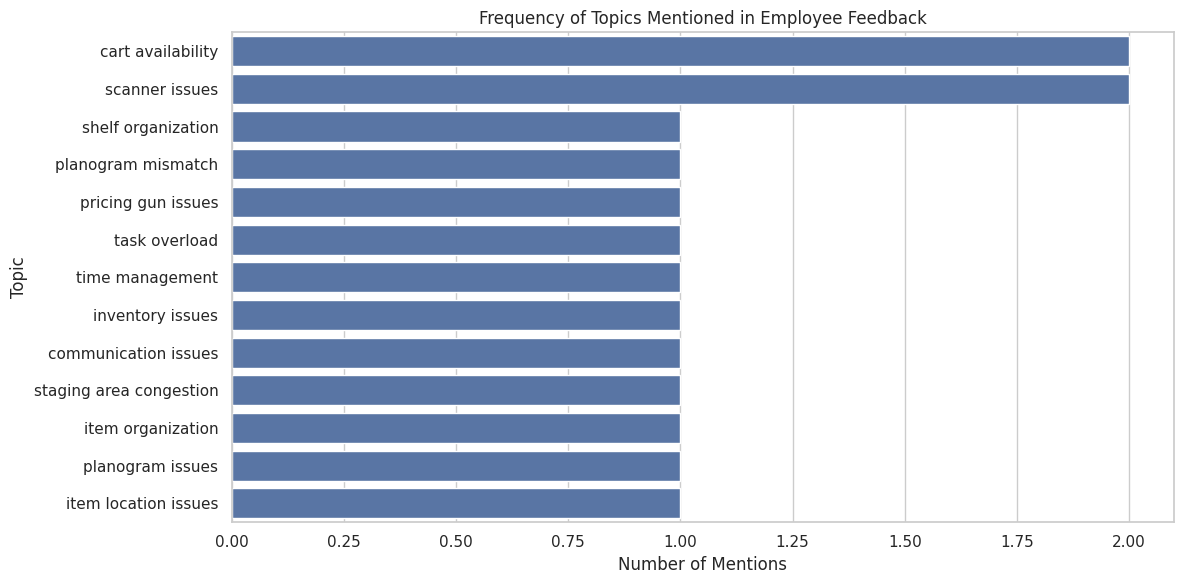

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

# Create a countplot of topic frequency
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y="topic", order=df["topic"].value_counts().index)

plt.title("Frequency of Topics Mentioned in Employee Feedback")
plt.xlabel("Number of Mentions")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


### Count Plot by Category

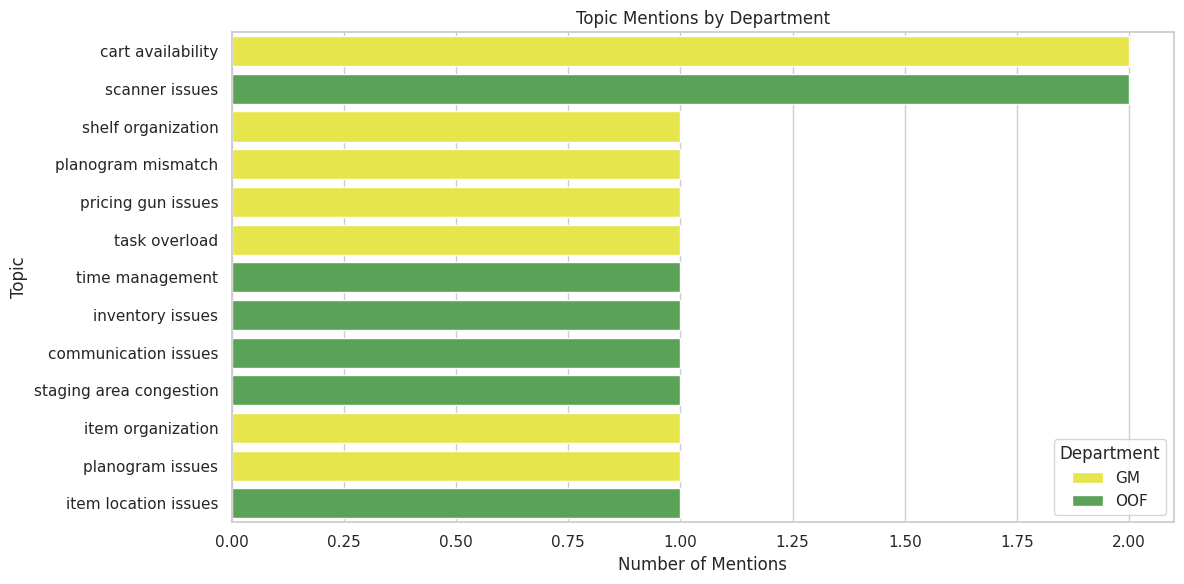

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y="topic", hue="department", order=df["topic"].value_counts().index, palette='Set1_r')

plt.title("Topic Mentions by Department")
plt.xlabel("Number of Mentions")
plt.ylabel("Topic")
plt.legend(title="Department")
plt.tight_layout()
plt.show()


In [18]:
df

,department,original_feedback,summary,topic
0,GM,The shelves in aisle 12 are constantly messy b...,Aisle 12 shelves remain messy due to customer ...,shelf organization
1,GM,Our pricing gun breaks down frequently. It slo...,"The pricing gun frequently breaks down, causin...",pricing gun issues
2,GM,We never have enough shopping carts near the e...,There is a shortage of shopping carts near the...,cart availability
3,GM,The planogram we receive doesn’t match the act...,The planogram discrepancies with the actual pr...,planogram mismatch
4,GM,Too many tasks assigned during a single shift....,The employee feels overwhelmed by the number o...,task overload
5,OOF,Pick times are too short for some items that a...,The pick times for items located far apart are...,time management
6,OOF,Sometimes online orders include out-of-stock i...,Online orders occasionally contain out-of-stoc...,inventory issues
7,OOF,The handheld scanner freezes mid-pick and we h...,The handheld scanner frequently freezes during...,scanner issues
8,OOF,We aren’t told when substitutes are approved —...,Employees are frustrated by the lack of commun...,communication issues
9,OOF,There’s not enough space in the staging area w...,The staging area becomes overcrowded with onli...,staging area congestion


### Investigate Most Common Topics

In [28]:
# Count topic occurrences
topic_counts = df["topic"].value_counts()

# Filter topics mentioned more than once
repeated_topics = topic_counts[topic_counts > 1]

# Show the most common ones
print("🔁 Topics mentioned more than once:\n")
print(repeated_topics)

for topic in repeated_topics.index:
    print(f"\n🟨 Topic: {topic}")
    topic_entries = df[df["topic"] == topic]
    for i, row in topic_entries.iterrows():
        print(f" - ({row['department']}) {row['original_feedback']}")


🔁 Topics mentioned more than once:

topic
cart availability    2
scanner issues       2
Name: count, dtype: int64

🟨 Topic: cart availability
 - (GM) We never have enough shopping carts near the entrance during busy hours.
 - (GM) We barely have enough carts in the front during rush hours — customers get annoyed.

🟨 Topic: scanner issues
 - (OOF) The handheld scanner freezes mid-pick and we have to restart it almost daily.
 - (OOF) The scanner crashes a lot — restarting it wastes at least 10 minutes each time.


# Build the Topic Summary Agent (Agent 2)

In [31]:
def topic_summary_agent(topic, feedback_list):
    system_prompt = f"""
You are a workplace assistant helping a store manager understand feedback grouped by the topic: "{topic}".

You will:
1. Summarize what the employees are saying overall.
2. Identify any patterns or repeated pain points.
3. Suggest a possible action or improvement.

Your reply MUST be in this JSON format:
{{
  "topic": "{topic}",
  "summary": "...",
  "suggested_action": "..."
}}
"""

    # Combine all relevant feedback into a single string
    combined_feedback = "\n".join(f"- {entry}" for entry in feedback_list)

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Here is the employee feedback:\n\n{combined_feedback}"}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.4
    )

    reply = response.choices[0].message.content.strip()

    try:
        return json.loads(reply)
    except json.JSONDecodeError:
        print(f"❌ Failed to parse topic summary for '{topic}':", reply)
        return {
            "topic": topic,
            "summary": "Could not parse summary",
            "suggested_action": "N/A"
        }


## 🧠 Suggested Action Generation (Agent 2)

The `"suggested_action"` field in the manager report is **generated dynamically** by the `topic_summary_agent()` function using an OpenAI LLM (`gpt-4o-mini`).

### 🔁 How It Works

1. **Input**:
   All original employee comments related to a single feedback `topic` are combined and passed to the agent.

2. **Prompt**:
   The LLM is instructed to:

   * Summarize what employees are saying
   * Identify repeated pain points
   * **Suggest a possible action or improvement**

3. **Output**:
   The model returns structured JSON including:

   ```json
   {
     "topic": "...",
     "summary": "...",
     "suggested_action": "..."
   }
   ```

4. **Example Output**:

   * **Summary**: "Employees report frequent freezing of handheld scanners causing workflow delays."
   * **Suggested Action**: "Investigate the current handheld scanner models and consider upgrading or scheduling regular maintenance checks."

### ✅ Notes

* Actions are **not hard-coded** — they are inferred directly from the employee feedback by the LLM.
* Temperature is set to `0.4` to allow useful variation while maintaining structure.
* You can improve consistency or specificity by adjusting:

  * **Prompt wording** (e.g., “Provide a low-cost, actionable next step…”)
  * **Model settings** (e.g., use `temperature=0.0` for more deterministic responses)




In [33]:
# Count topic occurrences
topic_counts = df["topic"].value_counts()

# Filter topics mentioned more than once
repeated_topics = topic_counts[topic_counts > 1]

print("🔁 Topics mentioned more than once:\n")
print(repeated_topics)

# Store results
topic_reports = []

# Loop through each repeated topic
for topic in repeated_topics.index:
    print(f"\n🟨 Topic: {topic}")

    topic_entries_df = df[df["topic"] == topic]
    topic_entries = topic_entries_df["original_feedback"].tolist()

    # Show the raw feedback for this topic
    for i, row in topic_entries_df.iterrows():
        print(f" - ({row['department']}) {row['original_feedback']}")

    # Run the topic summary agent
    print("\n🤖 Running topic_summary_agent...")
    report = topic_summary_agent(topic, topic_entries)
    topic_reports.append(report)

    # Print the result
    print(f"\n📋 Summary Report for '{topic}':")
    print(f"📝 Summary: {report['summary']}")
    print(f"✅ Suggested Action: {report['suggested_action']}")



🔁 Topics mentioned more than once:

topic
cart availability    2
scanner issues       2
Name: count, dtype: int64

🟨 Topic: cart availability
 - (GM) We never have enough shopping carts near the entrance during busy hours.
 - (GM) We barely have enough carts in the front during rush hours — customers get annoyed.

🤖 Running topic_summary_agent...

📋 Summary Report for 'cart availability':
📝 Summary: Employees report a consistent shortage of shopping carts near the entrance during busy and rush hours, leading to customer frustration.
✅ Suggested Action: Increase the number of shopping carts available at the entrance during peak hours and consider implementing a cart management system to ensure availability.

🟨 Topic: scanner issues
 - (OOF) The handheld scanner freezes mid-pick and we have to restart it almost daily.
 - (OOF) The scanner crashes a lot — restarting it wastes at least 10 minutes each time.

🤖 Running topic_summary_agent...

📋 Summary Report for 'scanner issues':
📝 Summary


# 🛠 Let’s Build `draft_manager_email() (Agent 3)

We now have:

* Structured feedback per employee
* Clustered topic summaries
* Suggested actions

### 🎯 Goal: Generate an email the store manager could actually read and act on

---

## 🧠 What the Email Agent Should Include

The agent (`draft_manager_email()`) should:

1. Start with a brief **intro**
2. Highlight the **most mentioned issues**
3. For each issue:

   * State the **topic**
   * Show the **summary**
   * Suggest an **action**
4. End with a positive, forward-looking note

---

### 📄 Example Email Output

> **Subject**: Weekly Employee Feedback Summary – Key Themes & Actions
>
> Hi \[Manager Name],
>
> Here’s a summary of the most common feedback themes from the floor this week:
>
> 🟨 **Scanner Issues**
> *Summary*: Employees are experiencing frequent freezing and crashing of handheld scanners.
> *Suggested Action*: Investigate current scanner models and consider upgrading or scheduling maintenance.
>
> 🟨 **Cart Availability**
> *Summary*: There are not enough carts available during peak hours, frustrating customers.
> *Suggested Action*: Increase cart monitoring or allocate staff to cart returns.
>
> Thanks for prioritizing employee insight. Let me know if you'd like a deeper dive on any of these topics.




In [36]:
def draft_manager_email(topic_reports):
    system_prompt = """
You are an assistant generating a weekly summary email to a store manager based on structured employee feedback.

Each topic has a summary and a suggested action. Your email should:
- Start with a brief, professional intro
- List each topic with its summary and suggested action
- Use simple, clear, and friendly language
- End with a short, positive closing

Output the email body as plain text only.
"""

    # Prepare content summary to feed in
    content = ""
    for topic in topic_reports:
        content += f"""Topic: {topic['topic']}
Summary: {topic['summary']}
Suggested Action: {topic['suggested_action']}

"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Here is the summarized feedback:\n\n{content}"}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.4
    )

    email_text = response.choices[0].message.content.strip()
    return email_text

# Generate the email
email_output = draft_manager_email(topic_reports)

# Print it nicely
print("\n📬 Weekly Feedback Summary Email:\n")
print(email_output)


📬 Weekly Feedback Summary Email:

Subject: Weekly Employee Feedback Summary

Dear [Store Manager's Name],

I hope this message finds you well. Here’s a summary of the employee feedback we received this week, along with suggested actions for each topic.

**Topic: Cart Availability**  
**Summary:** Employees report a consistent shortage of shopping carts near the entrance during busy and rush hours, leading to customer frustration.  
**Suggested Action:** Increase the number of shopping carts available at the entrance during peak hours and consider implementing a cart management system to ensure availability.

**Topic: Scanner Issues**  
**Summary:** Employees are experiencing frequent freezing and crashing of handheld scanners, which disrupts their workflow and leads to significant time loss due to the need for restarts.  
**Suggested Action:** Investigate the current handheld scanner models and consider upgrading to more reliable devices or implementing regular maintenance checks to m

In [37]:
def draft_manager_email(topic_reports, manager_name="Store Manager", sender_name="Micah Shull", sender_title="Data Scientist"):
    system_prompt = f"""
You are an assistant generating a weekly summary email to a store manager named {manager_name} based on structured employee feedback.

Each topic has a summary and a suggested action. Your email should:
- Start with a professional but friendly intro
- Clearly list each topic with its summary and suggested action
- End with a positive closing
- Use plain text line breaks — no markdown or special formatting

Sign the email from {sender_name}, {sender_title}.
"""

    # Prepare the list of topics
    content = ""
    for topic in topic_reports:
        content += f"""Topic: {topic['topic']}
Summary: {topic['summary']}
Suggested Action: {topic['suggested_action']}

"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Here is the summarized feedback:\n\n{content}"}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.4
    )

    return response.choices[0].message.content.strip()

# Generate personalized email
email_text = draft_manager_email(
    topic_reports,
    manager_name="Brandon",  # customize as needed
    sender_name="Micah Shull",
    sender_title="Data Scientist"
)

# Print with clear newlines
print("\n📬 Weekly Feedback Summary Email\n" + "-"*40)
for line in email_text.split("\n"):
    print(line.strip())



📬 Weekly Feedback Summary Email
----------------------------------------
Subject: Weekly Summary of Employee Feedback

Hi Brandon,

I hope this message finds you well! Below is the weekly summary of employee feedback, along with suggested actions for each topic.

Topic: Cart Availability
Summary: Employees report a consistent shortage of shopping carts near the entrance during busy and rush hours, leading to customer frustration.
Suggested Action: Increase the number of shopping carts available at the entrance during peak hours and consider implementing a cart management system to ensure availability.

Topic: Scanner Issues
Summary: Employees are experiencing frequent freezing and crashing of handheld scanners, which disrupts their workflow and leads to significant time loss due to the need for restarts.
Suggested Action: Investigate the current handheld scanner models and consider upgrading to more reliable devices or implementing regular maintenance checks to minimize downtime.

Tha